In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from utils import Normalise
from dataset import ConcatSequence, HDF5Sequence
from pyRDS import fk
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from sklearn.cluster import SpectralClustering, KMeans, MiniBatchKMeans
from utils import space_grad, space_grad_mse_loss
from unet3d import Unet3D
from resnet import ResNet
from glob import glob
import time
import h5py

ModuleNotFoundError: No module named 'pyRDS'

In [15]:
# model = ResNet.load_from_checkpoint(glob("logs/resnet/lightning_logs/version_3/checkpoints/*.ckpt")[0])
model = ResNet.load_from_checkpoint(glob("logs/lightning_logs/version_5/checkpoints/*.ckpt")[0],
                                    root="/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/",
                                    paramset="3",
                                    batch_size=2,
                                    n_workers=0,
                                    frames_out=50)

print("Model contains {:,} parameters".format(model.parameters_count()))
filename = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/heartbeat_params3.hdf5"
fkset = HDF5Sequence(filename, model.frames_in, model.frames_out, model.step, transform=Normalise())

Model contains 140,305 parameters


### Network prediction

In [16]:
# get data
device = torch.device("cuda:1")
sequence = torch.as_tensor(fkset[400])

# to gpu
model = model.to(device)
sequence = sequence.to(device)

# format data
x = sequence[:model.frames_in]
y = sequence[model.frames_in:]

# infer
start = time.time()
pred = model.infer(x)
elapsed = time.time() - start
print(pred.shape)

print("Computation time: {:.6f}ms".format(elapsed))
print("Input")

# error
mae = torch.nn.functional.l1_loss(pred[:, 2], y[:, 2].cpu(), reduction="none")

torch.Size([50, 3, 256, 256])
Computation time: 1.336370ms
Input


In [17]:
# plot
rows = 25
figsize = (100,20)

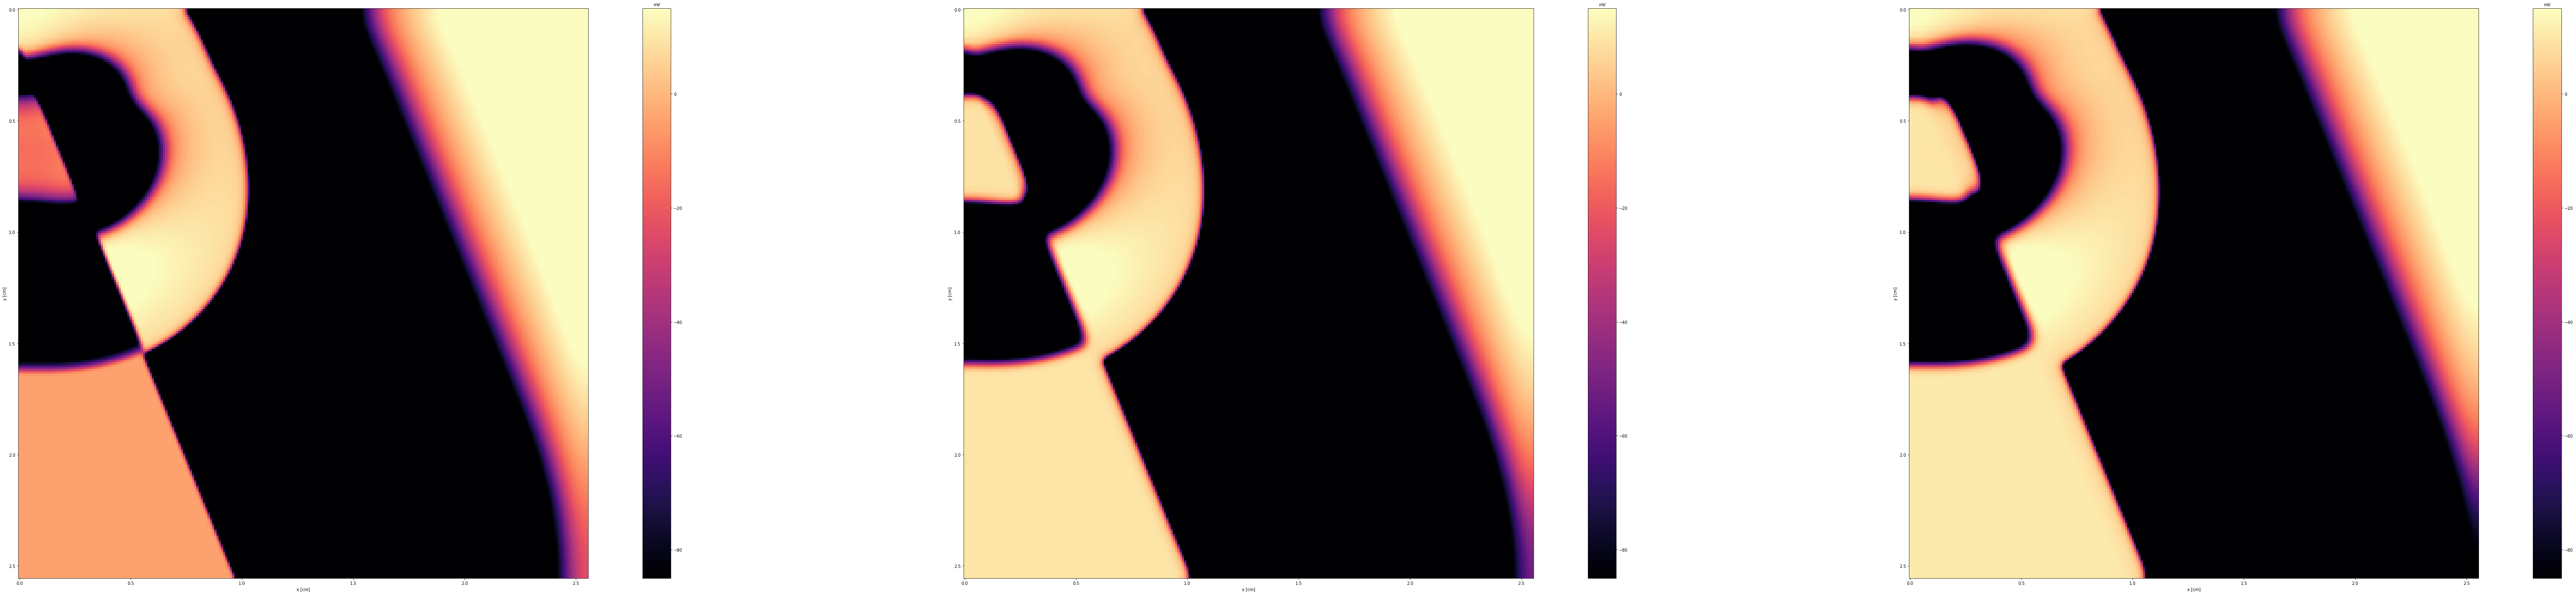

Prediction


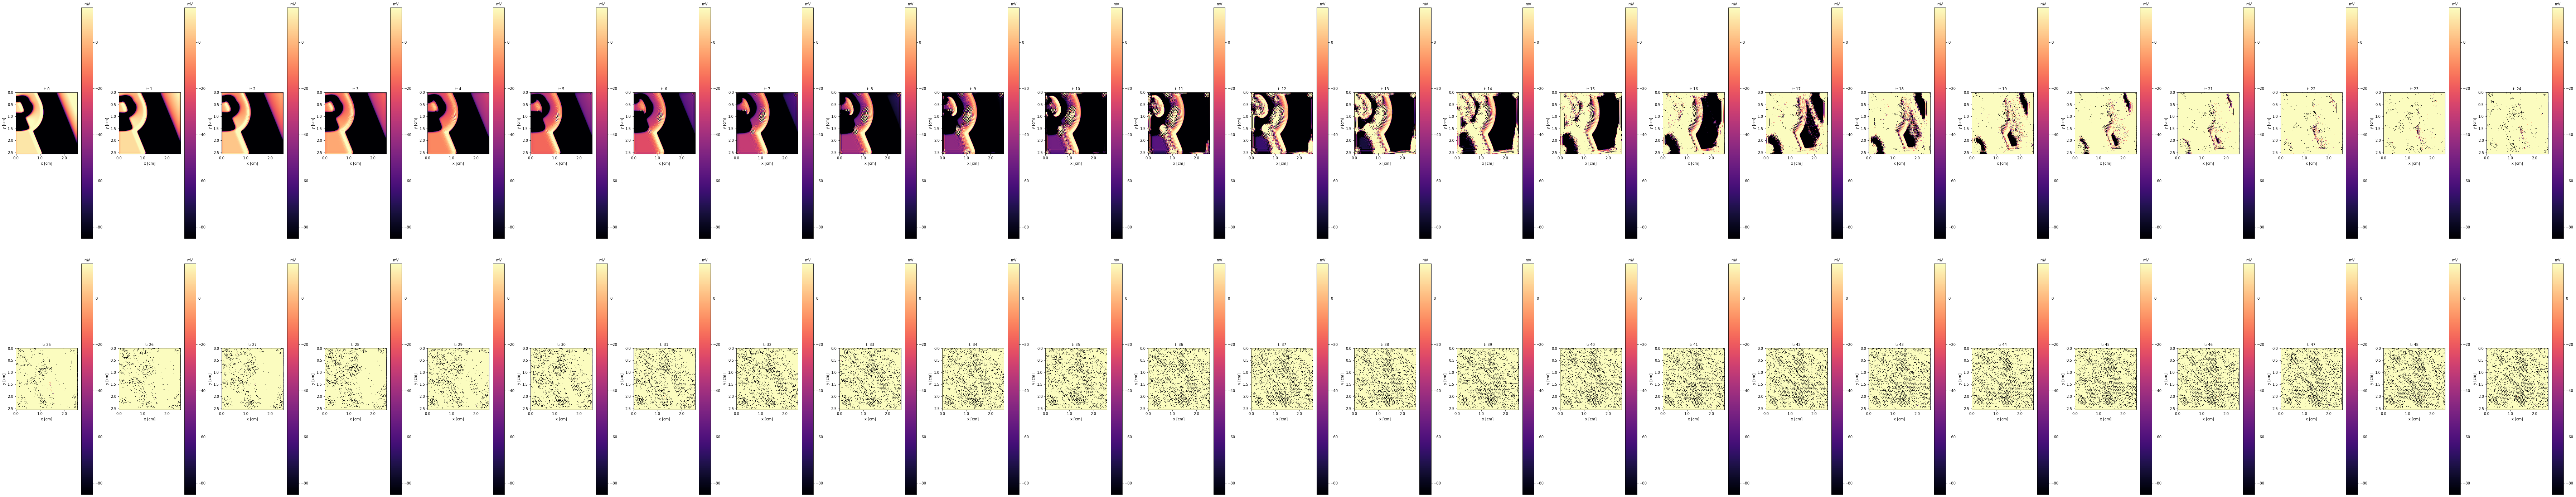

Truth


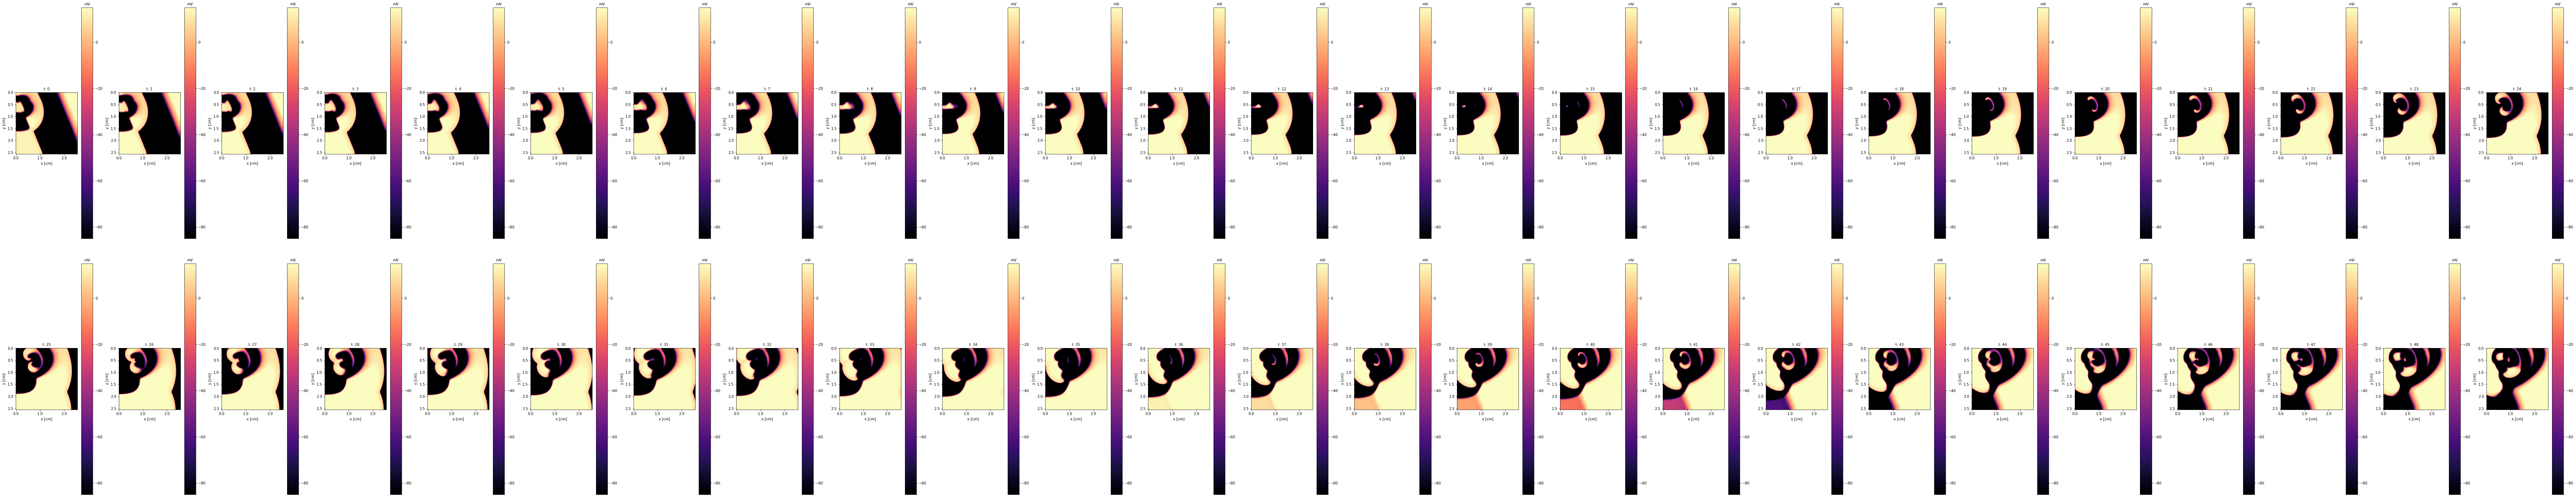

L1 loss


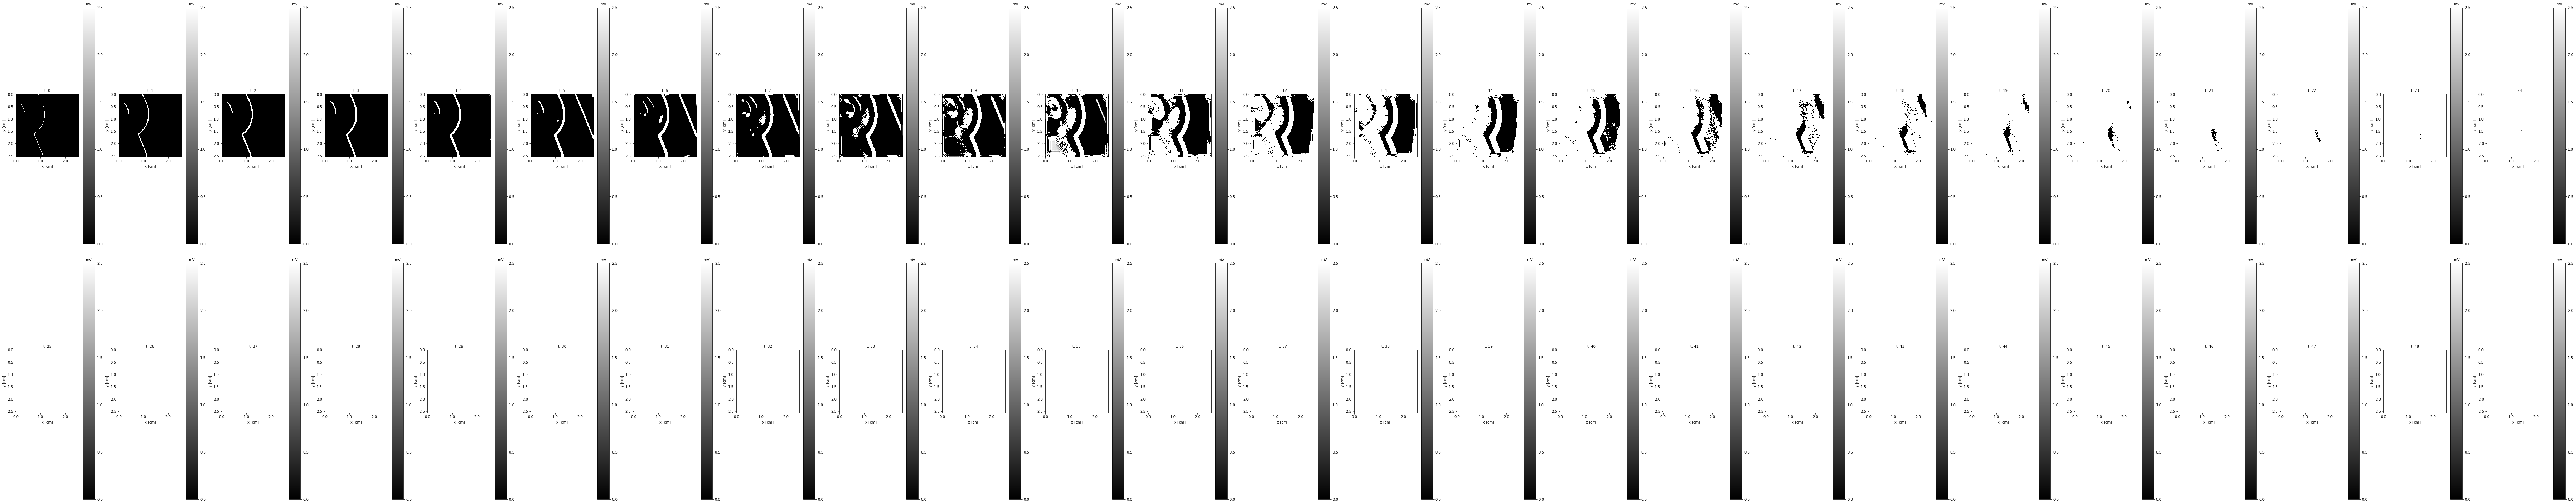

In [18]:
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(x[:, 2].detach().cpu()), rows=rows, figsize=figsize)
plt.show()
print("Prediction")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(pred[:, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("Truth")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(y[:, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("L1 loss")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(mae.detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)), vmin=0, vmax=2.5, cmap="gray")
plt.show()

## Testing gradients

In [ ]:
dx, dy = space_grad(torch.as_tensor(value))
dxx, dxy = space_grad(torch.as_tensor(dx))
dyx, dyy = space_grad(torch.as_tensor(dy))

fig, ax = plt.subplots(3, 4, figsize=(15, 12))

ax[0, 0].set_title("dx")
im = ax[0, 0].imshow(dx, vmin=-1, vmax=1, cmap="RdBu")

ax[0, 1].set_title("dy")
im = ax[0, 1].imshow(dy, vmin=-1, vmax=1, cmap="RdBu")

ax[0, 2].set_title("dx + dy")
im = ax[0, 2].imshow(dx + dy, vmin=-1, vmax=1, cmap="RdBu")

ax[0, 3].set_title("torch.abs(dx) + torch.abs(dy)")
im = ax[0, 3].imshow(torch.abs(dx) + torch.abs(dy), vmin=-1, vmax=1, cmap="RdBu")


ax[1, 0].set_title("dxx")
im = ax[1, 0].imshow(dxx, vmin=-1, vmax=1, cmap="RdBu")

ax[1, 1].set_title("dxy")
im = ax[1, 1].imshow(dxy, vmin=-1, vmax=1, cmap="RdBu")

ax[1, 2].set_title("dxx + dxy")
im = ax[1, 2].imshow(dxx + dxy, vmin=-1, vmax=1, cmap="RdBu")

ax[1, 3].set_title("torch.abs(dxx) + torch.abs(dxy)")
im = ax[1, 3].imshow(torch.abs(dxx) + torch.abs(dxy), vmin=-1, vmax=1, cmap="RdBu")


ax[2, 0].set_title("dyx")
im = ax[2, 0].imshow(dyx, vmin=-1, vmax=1, cmap="RdBu")

ax[2, 1].set_title("dyy")
im = ax[2, 1].imshow(dyy, vmin=-1, vmax=1, cmap="RdBu")

ax[2, 2].set_title("dyx + dyy")
im = ax[2, 2].imshow(dyx + dyy, vmin=-1, vmax=1, cmap="RdBu")

ax[2, 3].set_title("torch.abs(dyx) + torch.abs(dyy)")
im = ax[2, 3].imshow(torch.abs(dyx) + torch.abs(dyy), vmin=-1, vmax=1, cmap="RdBu")

In [ ]:
a, b = pred[0, 0, 2], y[0, 0, 2]
ax, ay = space_grad(a)
bx, by = space_grad(b)
a_grad = torch.abs(ax) + torch.abs(ay)
b_grad = torch.abs(bx) + torch.abs(by)

grad = Normalise()((a_grad.detach() - b_grad.detach()).exp())
im = plt.imshow(grad, vmin=-1, vmax=1, cmap="RdBu")
plt.colorbar(im)

## Blob detection using clustering

In [ ]:
class KMeans:
    def __init__(self, n_clusters=10, n_iter=100):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.labels_ = None
        self.cluster_centers_ = None
        
    def fit(self, x):
        N, D = x.shape  # Number of samples, dimension of the ambient space

        c = x[:self.n_clusters, :].clone()  # Simplistic random initialization
        x_i = torch.tensor(x[:, None, :])  # (Npoints, 1, D)

        for i in range(self.n_iter):

            c_j = torch.tensor(c[None, :, :])  # (1, Nclusters, D)
            D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
            cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

            Ncl = torch.bincount(cl)  # Class weights
            for d in range(D):  # Compute the cluster centroids with torch.bincount:
                c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl
        self.labels_ = cl
        self.cluster_centers_ = c

In [ ]:
km = KMeans()
km.fit(torch.as_tensor(fkset[1500:1532]).flatten().view(-1, 1).cuda())
km.labels_

In [ ]:
class KMeans:
    def __init__(self, n_clusters=10, n_iter=100):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.labels_ = None
        self.cluster_centers_ = None
        
    def fit(self, x):
        N, D = x.shape  # Number of samples, dimension of the ambient space

        c = x[:self.n_clusters, :].clone()  # Simplistic random initialization
        x_i = torch.tensor(x[:, None, :])  # (Npoints, 1, D)

        for i in range(self.n_iter):

            c_j = torch.tensor(c[None, :, :])  # (1, Nclusters, D)
            D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
            cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

            Ncl = torch.bincount(cl)  # Class weights
            for d in range(D):  # Compute the cluster centroids with torch.bincount:
                c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl
        self.labels_ = cl
        self.cluster_centers_ = c

In [ ]:
km = KMeans()
km.fit(torch.as_tensor(fkset[]).flatten().view(-1, 1))
labels = cl.labels_.reshape(256, 256)

masks = np.zeros((km.n_clusters, 256, 256))
for i in range(len(value)):
    for j in range(value.shape[1]):
        masks[labels[i, j], i, j] = 1
        
fig, ax = plt.subplots(1, km.n_clusters + 1, figsize=(50, 30))
ax[0].imshow(value, cmap="gray")
for i in range(km.n_clusters):
    ax[i + 1].imshow(masks[i], cmap="gray")

In [ ]:
%%time
# reshape
points = []
for i in range(len(value)):
    for j in range(value.shape[1]):
        points.append(np.array([i, j, value[i, j]]))
points = np.array(points)

# cluster
cl = KMeans(10)
cl.fit(torch.as_tensor(value).flatten().reshape(-1, 1))

labels = cl.labels_.reshape(256, 256)
clusters = {}
masks = np.zeros((cl.n_clusters, 256, 256))
for i in range(len(value)):
    for j in range(value.shape[1]):
        masks[labels[i, j], i, j] = 1
    
fig, ax = plt.subplots(1, cl.n_clusters + 1, figsize=(50, 30))
ax[0].imshow(value, cmap="gray")
for i in range(cl.n_clusters):
    ax[i + 1].imshow(masks[i], cmap="gray")

In [ ]:
def quantize(x):
    cl = MiniBatchKMeans(10)
    cl.fit(x.flatten().reshape(-1, 1))

    labels = cl.labels_.reshape(x.shape)
    clusters = {}
    masks = np.zeros((cl.n_clusters, *x.shape))
    for i in range(len(x)):
        for j in range(x.shape[1]):
            masks[labels[i, j], i, j] = 1
    return masks, cl.cluster_centers_    
    
def quant_loss(y_hat, y):
    masks_y_hat = quantize(y_hat)
    masks_y = quantize(y)
    return nn.functional.mse_loss(y_hat, y, reduction="sum") / y_hat.size(0)

def plot_masks(masks):
    fig, ax = plt.subplots(1, len(masks), figsize=(50, 30))
    for i in range(len(masks)):
        ax[i].imshow(masks[i], cmap="gray")

In [ ]:
masks, means = quantize(value)
plot_masks(masks)

## Blob detection using MSER

In [ ]:
import cv2

vis = value.copy()
mser = cv2.MSER_create(_min_area=10, _max_area=int(1e5))
regions, points = mser.detectRegions(value.reshape(256, 256, 1).astype("uint8"))
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 255))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(value, cmap="gray")
ax[1].imshow(vis, cmap="gray")

mask = np.zeros_like(value)
mask[regions[2]] = 0
plt.imshow(mask)

In [ ]:

        energy_loss = energy_loss * self.loss_weights.get("energy_loss",from bnaf import BNAF

In [ ]:
BNAF(512, 6, 512)

In [ ]:
from utils import time_grad, time_grad_loss

root = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/"
fkset = FkDataset(root, 2, 20, 5, transform=Normalise(),
                  keys=["spiral_params3.hdf5", "heartbeat_params3.hdf5", "three_points_params3.hdf5"])

sequence = fkset[1500]
t_grad = time_grad(torch.as_tensor(sequence).unsqueeze(0))
fig, ax = plt.subplots(1, len(sequence) - 1, figsize=(60, 3))
for i in range(len(sequence) - 1):
    im = ax[i].imshow(t_grad[0, i, 2], cmap="gray")
    plt.colorbar(im, ax=ax[i])

In [ ]:
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(sequence[:, 2]), figsize=(20, 10))


In [ ]:
frames_in = 2
batch = torch.randn(32, 22, 3, 256, 256)
x = batch[:, :frames_in]
print(x.shape)
y = batch[:, frames_in]
print(y.shape)

In [ ]:
x = torch.randn(32, 3, 256, 256)
y = torch.randn(32, 3, 256, 256)
torch.stack([x, y], dim=1).shape


In [ ]:
a = torch.ones(1, 3, 256, 256)
b = torch.ones(1, 3, 256, 256) * 1.5
c = torch.zeros(1, 3, 256, 256)
x = torch.cat([a, b, c])
x.shape

In [14]:
list(range(10))[-2:]

[8, 9]

In [21]:
idx = 15
frames_in = 8
frames_out = 7
step = 5

a = range(100)[idx: idx + (frames_in + frames_out) * step: step]

In [22]:
sl = slice(idx, idx + (frames_in + frames_out) * step, step)
b = range(100)[sl]

In [23]:
sl.stop

90

In [11]:
a

range(15, 90, 5)

In [12]:
b

range(15, 90, 5)

In [18]:
filepath = glob("/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/*.hdf5")[0]
f = h5py.File(filepath, "r")
print(f.keys())

<KeysViewHDF5 ['duration', 'field', 'params', 'period', 'start', 'states', 'states_256', 'stimuli']>


In [15]:
f["duration"][:]

array([2, 2])

In [19]:
fk.io.load_stimuli(f)

[{'field': array([[0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'start': 0,
  'duration': 2,
  'period': 14000},
 {'field': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'start': 26000,
  'duration': 2,
  'period': 20000}]

In [131]:
s = HDF5Sequence(filepath, 3, 5, 5, clean_from_stimuli=True)

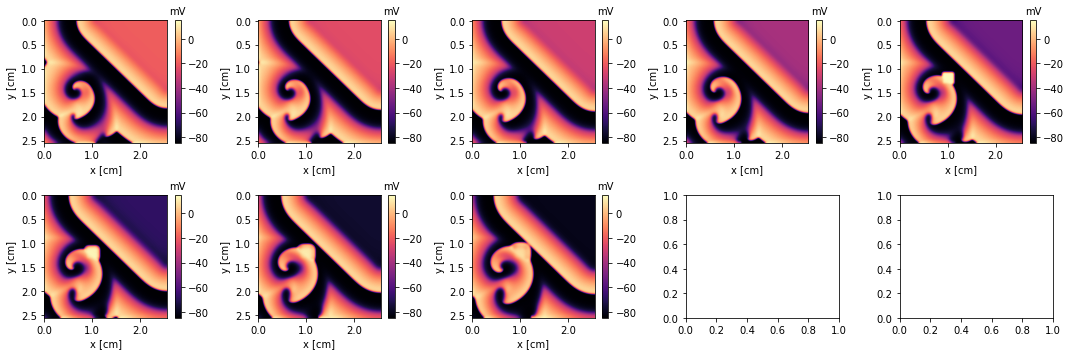

In [133]:
a = fk.plot.show_grid(fk.convert.u_to_V(random.choice(s)[:, 2]), figsize=(15, 5))

In [112]:
s.filename

'/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/heartbeat_params8.hdf5'

In [1]:
f.close()

NameError: name 'f' is not defined

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytorch_lightning as pl
from realnvp import RealNVP
from glob import glob
from sklearn import datasets

In [16]:
!ls -l logs/realnvp/lightning_logs

total 164
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 16:34 version_0
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 17:50 version_1
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 18:19 version_10
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 18:19 version_11
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 18:20 version_12
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 21:44 version_13
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 21:52 version_14
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:03 version_15
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:03 version_16
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:16 version_17
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:17 version_18
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:19 version_19
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 17:52 version_2
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:21 version_20
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:22 version_21
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:24 version_22
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:25 version_23
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:25 version_24
drwxrwxr-x 3 ep119 ep

In [17]:
model = RealNVP.load_from_checkpoint(glob("logs/realnvp/lightning_logs/version_40/checkpoints/*.ckpt")[0]).cuda()

In [18]:
samples = model.sample(2000).detach().cpu()
moons = datasets.make_moons(2000, noise=0.1)[0]

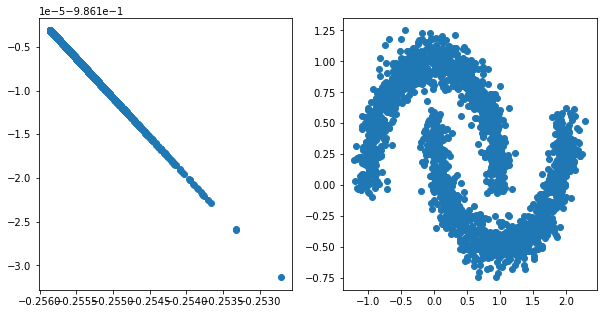

In [21]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(samples[:, 0], samples[:, 1])
ax[1].scatter(moons[:, 0], moons[:, 1])

In [22]:
[model.transformations[i].mask for i in range(len(model.transformations))]

[tensor([1, 0], device='cuda:0'),
 tensor([0, 1], device='cuda:0'),
 tensor([1, 0], device='cuda:0'),
 tensor([0, 1], device='cuda:0'),
 tensor([1, 0], device='cuda:0')]

In [14]:
import torch
a = torch.arange(10) % 2
a

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [15]:
torch.roll(a, -1)

tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from deepreact import DeepReact
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateLogger, ModelCheckpoint
from pytorch_lightning.callbacks.base import Callback

In [9]:
n_diffusion_layers = 5
n_diffusion_filters = 5
diffusion_kernel_size = (1, 5, 5)
n_reaction_components = 5
n_reaction_layers = 5
n_reaction_filters = 5
reaction_kernel_size = (1, 5, 5)
frames_in = 5
frames_out = 5
model = DeepReact(
    n_diffusion_layers,
    n_diffusion_filters,
    diffusion_kernel_size,
    n_reaction_components,
    n_reaction_layers,
    n_reaction_filters,
    reaction_kernel_size,
    frames_in,
    frames_out,
    1, "", "", "", 32, 3).cuda()

In [13]:
u = torch.randn(model.hparams.batch_size, model.hparams.frames_in, 1, 256, 256).cuda()

In [14]:
solve = model.solve(u).shape

In [16]:
batch = torch.randn(model.hparams.batch_size, model.hparams.frames_in + model.hparams.frames_in, 5, 256, 256).cuda()

In [17]:
forward = model(u)

RuntimeError: start (5) + length (5) exceeds dimension size (5).